In [1]:
# This code is used for JHU CS 482/682: Deep Learning 2019 Spring Project
# Copyright: Zhaoshuo Li, Ding Hao, Mingyi Zheng
!pip install tensorboardX visdom image_slicer
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import DataLoader, Dataset
#from torchvision import transforms
import torchvision.transforms.functional as TF

import copy
import numpy as np
import random
from tensorboardX import SummaryWriter

import transforms
from dataset import *
from visualization import *
from label_conversion import *
from dice_loss import *
from model_trainning import *
from model_from_ternaus import *
from unet import *

from google.colab import drive
drive.mount('/mydrive')

Drive already mounted at /mydrive; to attempt to forcibly remount, call drive.mount("/mydrive", force_remount=True).


In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda


# Seed pytorch and numpy and random

In [0]:
# IMPORTANT!
# must seed the same value each time when training a new network
seed = 256
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pretrain_seed = 128

## Hyperparameters

In [0]:
train_batch_size = 10
validation_batch_size=10
learning_rate = 0.001
num_epochs = 30
num_class = 12
num_superclasses = 2
super2sub = [[0,4,5,6,10],[1,2,3,7,8,9,11]]
num_filters = 64

In [0]:
#dice_loss = BatchWeightDICELoss()
weights = torch.ones((num_class,1)).to(device = device)
dice_loss = SuperLabelDICELoss(weights,_lambda=0.5) 
# dice_loss = DICELoss(weights)

## Visualization

In [0]:
# Initialize the visualization environment
writer = SummaryWriter()

## Unet

In [7]:
#initialize model
model = SuperLabelAlbuNet(num_super_class = num_superclasses,num_classes = num_class,num_filters = num_filters, pretrained = True, is_deconv = True, super2sub=super2sub)
#model_dict = model.state_dict()
# pretrained_dict = torch.load("/mydrive/My Drive/Colab Notebooks/trained_albunet.pt")
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in model_dict and "final" not in k)}
# 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# 3. load the new state dict
# model.load_state_dict(model_dict)
# freeze the pretrained feature.
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.super_class_classifier.parameters():
#     param.requires_grad = True
# for param in model.final_classifier.parameters():
#     param.requires_grad = True
# model = AlbuNet(num_classes = num_class,num_filters = num_filters, pretrained = True, is_deconv = True)
model.to(device)

SuperLabelAlbuNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

## Optimizer and Scheduler and loss

In [0]:
# intialize optimizer and lr decay
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

## Baseline Unet16 (unet with vgg16 backbone not pretrained), without augmentation.

In [0]:
# IMPORTANT!
# must seed the same value each time when training a new network
seed = 256
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

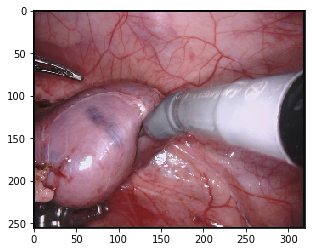

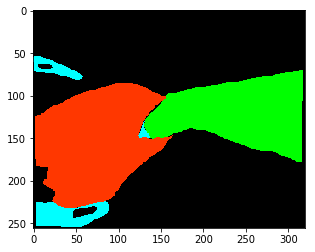

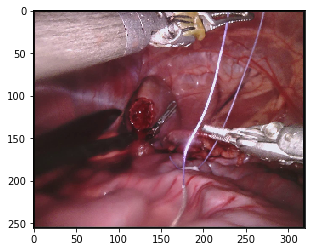

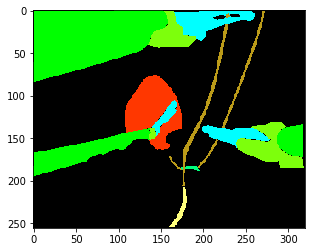

In [10]:
# define transform
image_aug = Compose([
    Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5),p=1),
])
train_dataset = MICCAIDataset(data_path = "/mydrive/My Drive/Colab Notebooks/data/",data_type = "train", transform_image=image_aug)
validation_dataset = MICCAIDataset(data_path = "/mydrive/My Drive/Colab Notebooks/data/",data_type = "validation", transform_image=image_aug)
label_converter = LabelConverter(data_path = "/mydrive/My Drive/Colab Notebooks/data/")

# # show one example
img,label = (train_dataset[0]['img'],train_dataset[0]['label'])
imshow(img.permute(1,2,0),denormalize=True)
colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
imshow(colorlabel)

# show one example
img,label = (validation_dataset[0]['img'],validation_dataset[0]['label'])
imshow(img.permute(1,2,0),denormalize=True)
colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
imshow(colorlabel)

In [0]:
# intialize the dataloader
train_generator = DataLoader(train_dataset,shuffle=True,batch_size=train_batch_size,num_workers=8)
validation_generator = DataLoader(validation_dataset,shuffle=True,batch_size=validation_batch_size,num_workers=8)

## Start training

In [12]:
best_model_wts, best_acc = run_training(model,device,num_class,scheduler,optimizer,dice_loss,num_epochs,train_generator,train_dataset,validation_generator,validation_dataset,writer,'/mydrive/My Drive/Colab Notebooks/super_label_albunet.pt')

Training Started!

EPOCH 1 of 30

Training Loss: 0.9400
0 Class, True Pos 59532128.0, False Pos 42949544.0, False Neg 11003404.0, Num Pixel 70535536.0, Dice score 0.69
1 Class, True Pos 11041581.0, False Pos 8264251.0, False Neg 2198973.0, Num Pixel 13240554.0, Dice score 0.68
2 Class, True Pos 3409893.0, False Pos 4761930.0, False Neg 3750448.0, Num Pixel 7160341.0, Dice score 0.44
3 Class, True Pos 430669.0, False Pos 1727428.0, False Neg 2769164.0, Num Pixel 3199833.0, Dice score 0.16
4 Class, True Pos 6147.0, False Pos 60387.0, False Neg 18194084.0, Num Pixel 18200232.0, Dice score 0.00
5 Class, True Pos 3310978.0, False Pos 8095289.0, False Neg 14543055.0, Num Pixel 17854032.0, Dice score 0.23
6 Class, True Pos 1407.0, False Pos 921746.0, False Neg 597456.0, Num Pixel 598863.0, Dice score 0.00
7 Class, True Pos 19050.0, False Pos 1319680.0, False Neg 877857.0, Num Pixel 896907.0, Dice score 0.02
8 Class, True Pos 0.0, False Pos 165165.0, False Neg 3218.0, Num Pixel 3218.0, Dice sc

## Test

In [0]:
# load test dataset
# load test dataset
test_dataset=MICCAIDataset(data_path = "/mydrive/My Drive/Colab Notebooks/data/",data_type = "test", transform_image=image_aug)
test_generator=DataLoader(test_dataset,shuffle=False,batch_size=4,num_workers=8)

In [0]:
# load model
model.load_state_dict(torch.load('/mydrive/My Drive/Colab Notebooks/super_label_albunet.pt'))
model.to(device)
print("Model loaded")

Model loaded


In [0]:
  final_dice = test(model,device,dice_loss,num_class,test_generator,test_dataset,writer)

Dice Score: 0.8307
0 Class, True Pos 16096912.0, False Pos 639520.0, Flase Neg 623557.0
1 Class, True Pos 3027490.0, False Pos 117314.0, Flase Neg 128939.0
2 Class, True Pos 1635486.0, False Pos 207880.0, Flase Neg 204670.0
3 Class, True Pos 760960.0, False Pos 116953.0, Flase Neg 107302.0
4 Class, True Pos 6265518.0, False Pos 293634.0, Flase Neg 247285.0
5 Class, True Pos 4002759.0, False Pos 172523.0, Flase Neg 207749.0
6 Class, True Pos 95271.0, False Pos 28616.0, Flase Neg 36459.0
7 Class, True Pos 139076.0, False Pos 16616.0, Flase Neg 23715.0
8 Class, True Pos 0.0, False Pos 0.0, Flase Neg 338.0
9 Class, True Pos 129091.0, False Pos 10087.0, Flase Neg 22883.0
10 Class, True Pos 2559640.0, False Pos 92786.0, Flase Neg 85848.0
11 Class, True Pos 192543.0, False Pos 17565.0, Flase Neg 24749.0
----------


# Data Augmentation

# Pretraining